In [ ]:
! pip install -q "gdown==5.2.0"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModel, AutoConfig
from PIL import Image
import requests
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Dataset

In [ ]:
!gdown --id 1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39
From (redirected): https://drive.google.com/uc?id=1aOm_WJ53R7lk16Azz_NSNumvFV3aNO39&confirm=t&uuid=5e338b78-5bbc-4bd3-b0dd-88e88151c469
To: /content/lung_cancer_dataset.zip
100% 178M/178M [00:03<00:00, 56.4MB/s]


In [ ]:
!unzip lung_cancer_dataset.zip

Archive:  lung_cancer_dataset.zip
   creating: lung_cancer_dataset/Bengin cases/
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (1).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (10).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (100).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (101).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (102).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (103).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (104).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (105).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (106).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (107).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (108).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (109).jpg  
  inflating: lung_cancer_dataset/Bengin cases/Bengin_case (11).jpg  
  inflating: 

In [ ]:
def loading_the_data(data_dir):
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        # selected_files = random.sample(filelist, 20)
        for file in filelist:
            fpath = os.path.join(foldpath, file)

            filepaths.append(fpath)
            labels.append(fold)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)

    return df

In [ ]:
data_dir = '/content/lung_cancer_dataset'
df = loading_the_data(data_dir)
df

,filepaths,labels
0,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
1,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
2,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
3,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
4,/content/lung_cancer_dataset/Malignant cases/M...,Malignant cases
...,...,...
1195,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
1196,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
1197,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases
1198,/content/lung_cancer_dataset/Bengin cases/Beng...,Bengin cases


In [ ]:
class LungCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, class_dict=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_dict = class_dict

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepaths']
        label = self.dataframe.iloc[idx]['labels']
        label = self.class_dict[label]
        label = torch.tensor(label)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
img_size = (224, 224)
batch_size = 32

In [ ]:
train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)
valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

classes = train_df['labels'].unique()
class_dict = {label: idx for idx, label in enumerate(classes)}
reverse_class_dict = {idx: label for label, idx in class_dict.items()}

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = LungCancerDataset(dataframe=train_df, transform=transform, class_dict=class_dict)
valid_dataset = LungCancerDataset(dataframe=valid_df, transform=transform, class_dict=class_dict)
test_dataset = LungCancerDataset(dataframe=test_df, transform=transform, class_dict=class_dict)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model

In [ ]:
# Define the Image Classification Model
class ImageClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(ImageClassificationModel, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-large')
        self.fc = nn.Linear(self.dino.config.hidden_size, num_classes)

    def forward(self, x):
        x = self.dino(x).last_hidden_state[:, 0, :]
        x = self.fc(x)
        return x

# Initialize the model
num_classes = 3
model = ImageClassificationModel(num_classes)

# Freeze all parameters in the model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last Dinov2Layer
for param in model.dino.encoder.layer[-1].parameters():
    param.requires_grad = True

# Optionally, also unfreeze the layernorm layer after the encoder
for param in model.dino.layernorm.parameters():
    param.requires_grad = True

# Optionally, unfreeze the classification head
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

ImageClassificationModel(
  (dino): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
   

# Train

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Epoch {epoch + 1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_corrects = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)

        val_acc = val_running_corrects.double() / len(valid_loader.dataset)

        print(f'Validation Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    model.load_state_dict(best_model_wts)
    return model


model = train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Loss: 2.7541 | Accuracy: 0.3646
Validation Accuracy: 0.5500
Epoch 2/10 | Loss: 0.8314 | Accuracy: 0.6208
Validation Accuracy: 0.7333
Epoch 3/10 | Loss: 0.5903 | Accuracy: 0.6958
Validation Accuracy: 0.5833
Epoch 4/10 | Loss: 0.4760 | Accuracy: 0.7531
Validation Accuracy: 0.7333
Epoch 5/10 | Loss: 0.3672 | Accuracy: 0.8615
Validation Accuracy: 0.8750
Epoch 6/10 | Loss: 0.2772 | Accuracy: 0.8865
Validation Accuracy: 0.8583
Epoch 7/10 | Loss: 0.2096 | Accuracy: 0.9177
Validation Accuracy: 0.9083
Epoch 8/10 | Loss: 0.1878 | Accuracy: 0.9260
Validation Accuracy: 0.8917
Epoch 9/10 | Loss: 0.2210 | Accuracy: 0.9094
Validation Accuracy: 0.9250
Epoch 10/10 | Loss: 0.1218 | Accuracy: 0.9583
Validation Accuracy: 0.9000


# Test

In [ ]:
# Test the model
model.eval()
test_running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / len(test_loader.dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.9083


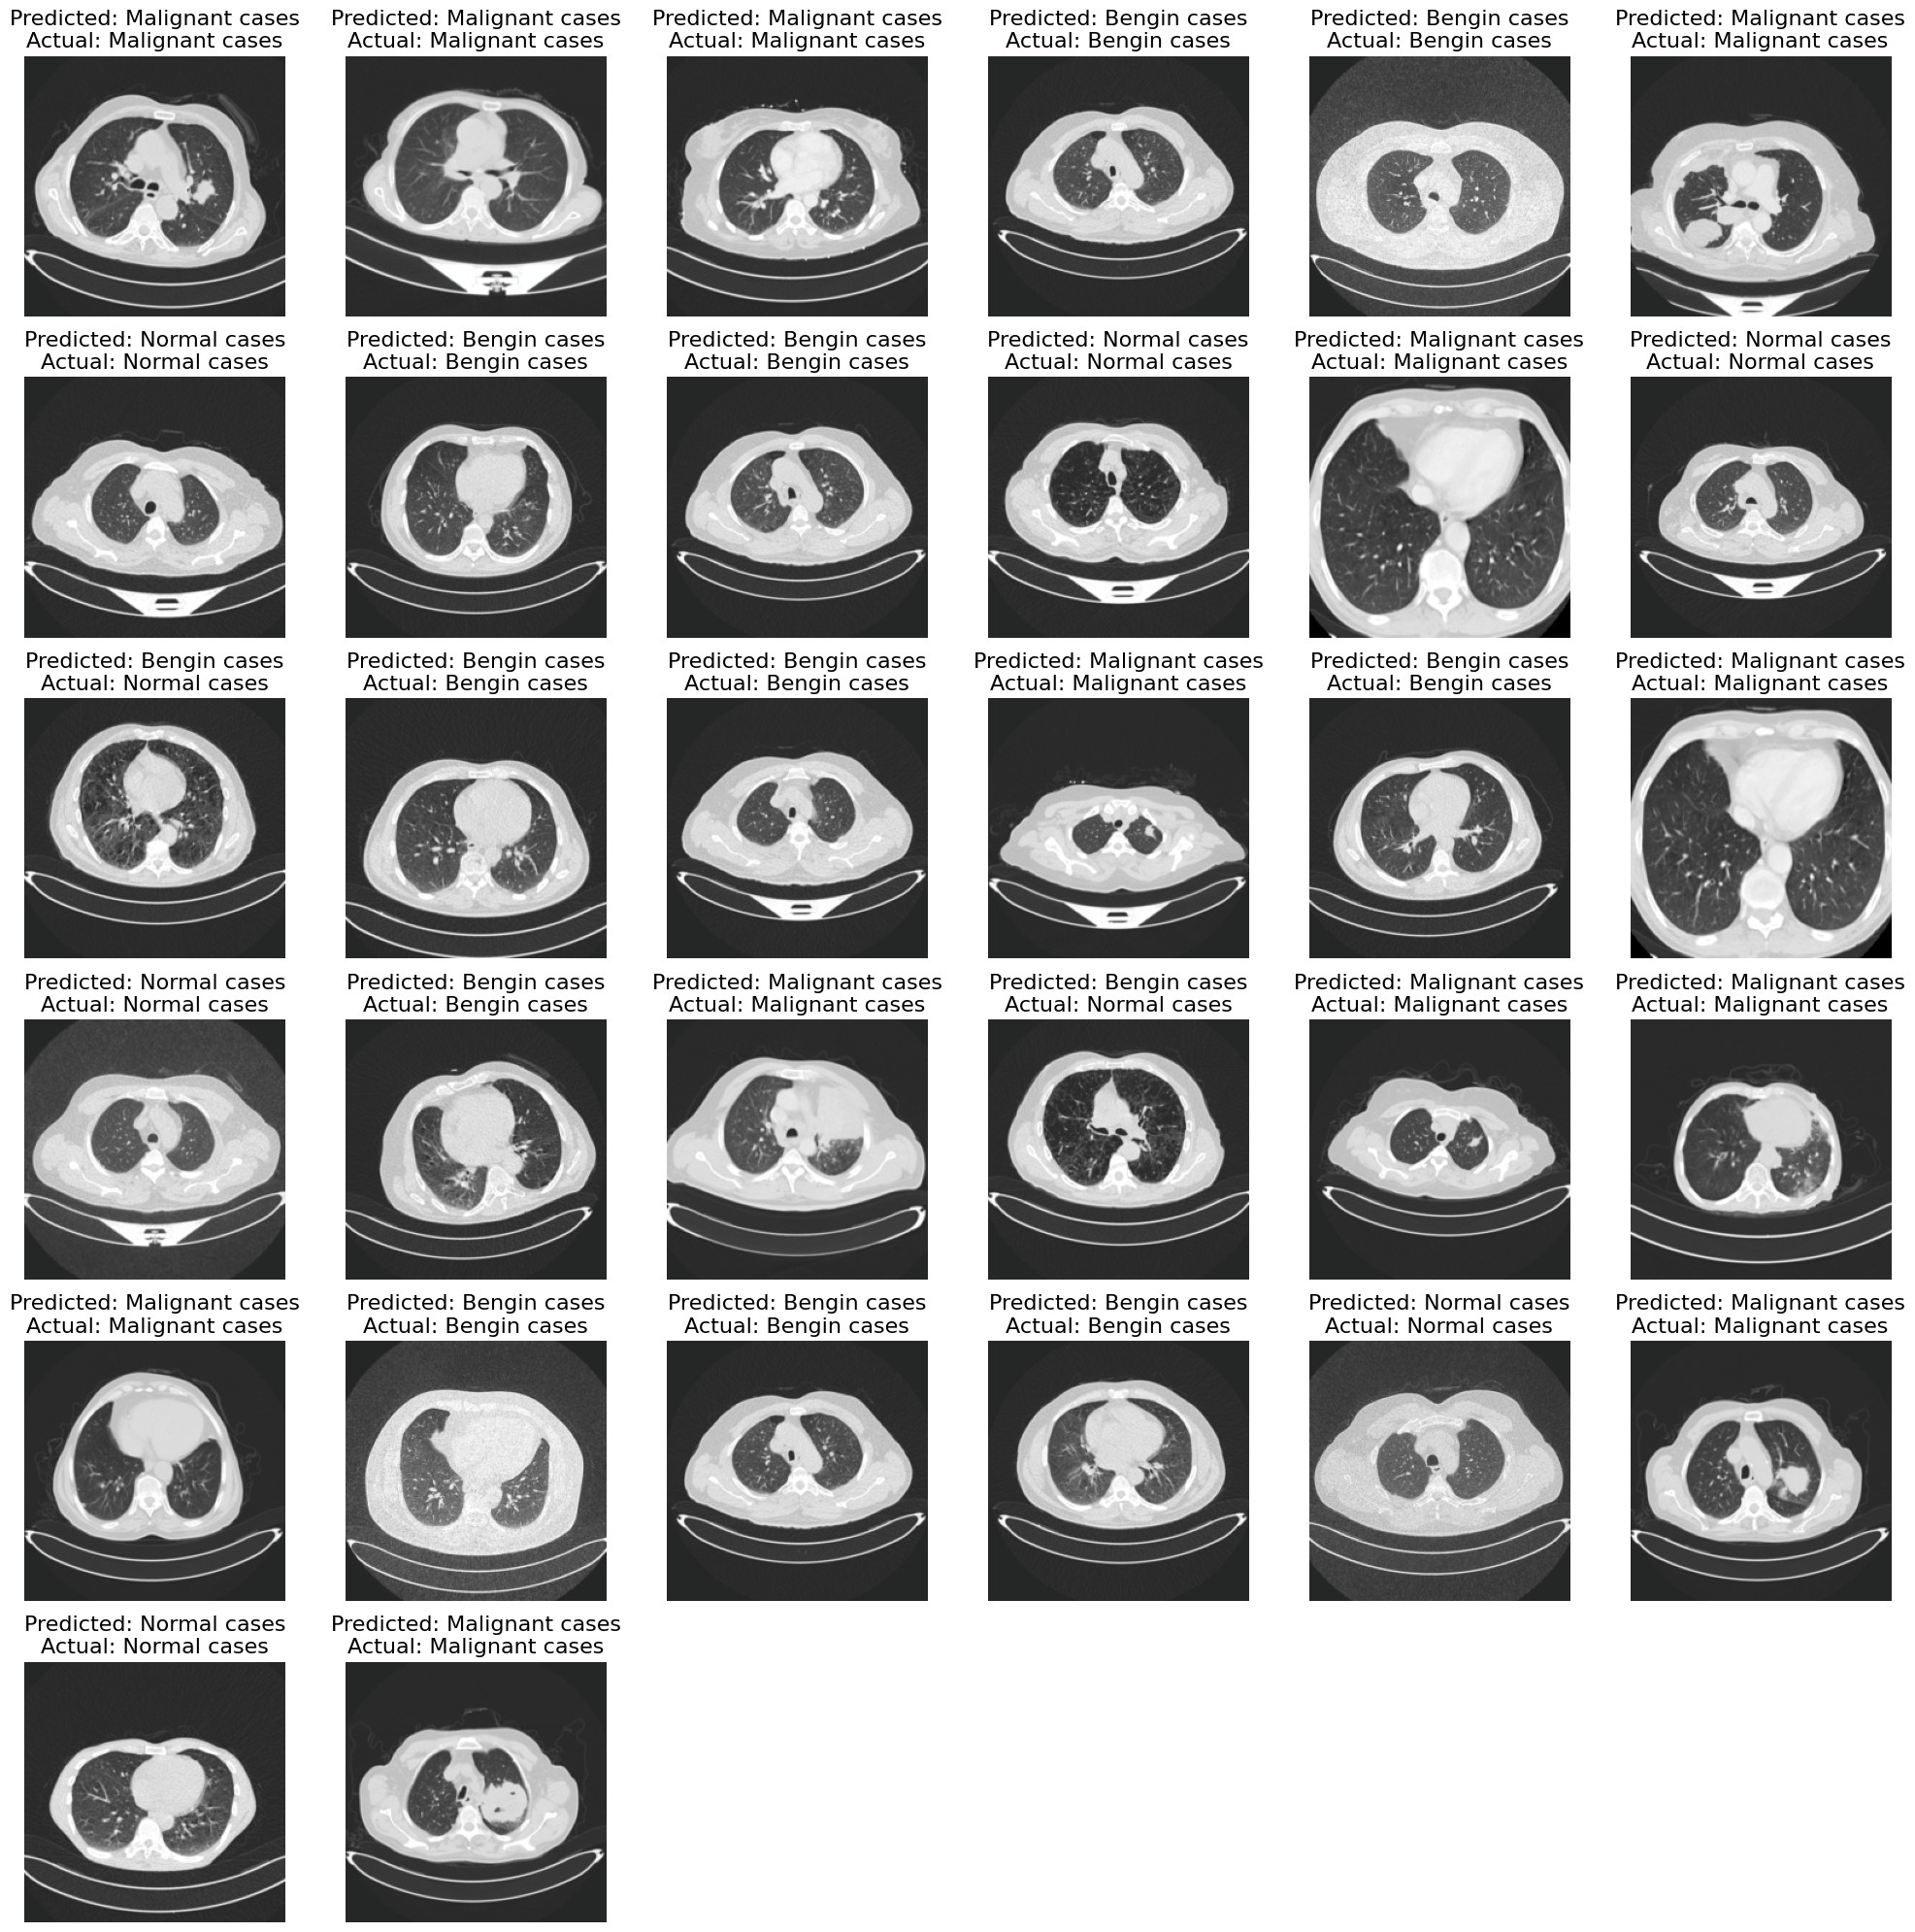

In [ ]:
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

outputs = model(inputs)
_, preds = torch.max(outputs, 1)

# Convert images to CPU and unnormalize
inputs = inputs.cpu().numpy().transpose(0, 2, 3, 1)
inputs = np.clip(inputs * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

plt.figure(figsize=(20, 20))
for i in range(len(inputs)):
    plt.subplot(6, 6, i + 1)
    plt.imshow(inputs[i])
    plt.title(f'Predicted: {reverse_class_dict[preds[i].item()]}\nActual: {reverse_class_dict[labels[i].item()]}', color='black', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), "dinov2_lung_cancer_detection.pth")

# Push to Hub

In [ ]:
from google.colab import userdata
from huggingface_hub import login, HfApi, create_repo

In [ ]:
login(token=userdata.get('niru_hf_write'))

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
create_repo("nirusanan/Lung_Cancer_Detection_DinoV2", private=True)

RepoUrl('https://huggingface.co/nirusanan/Lung_Cancer_Detection_DinoV2', endpoint='https://huggingface.co', repo_type='model', repo_id='nirusanan/Lung_Cancer_Detection_DinoV2')

In [ ]:
from huggingface_hub import upload_file

# Upload a single file
upload_file(
    path_or_fileobj="/content/dinov2_lung_cancer_detection.pth",
    path_in_repo="dinov2_lung_cancer_detection.pth",
    repo_id="nirusanan/Lung_Cancer_Detection_DinoV2",
    repo_type="model",
)


CommitInfo(commit_url='https://huggingface.co/nirusanan/Lung_Cancer_Detection_DinoV2/commit/6802f215eb8ffbc001daa9813cf176e833b079b7', commit_message='Upload dinov2_lung_cancer_detection.pth with huggingface_hub', commit_description='', oid='6802f215eb8ffbc001daa9813cf176e833b079b7', pr_url=None, pr_revision=None, pr_num=None)